# MLflow Tracking

In [32]:
import mlflow
import getpass
import subprocess
import pickle
import numpy as np
import xgboost
from matplotlib import pyplot as plt
from pyngrok import ngrok, conf

## Set up MLflow

In [4]:
mlflow_path = '../resources/mlflow'
mlflow.set_tracking_uri(f'file:{mlflow_path}')

In [ ]:
mlflow.set_experiment('XGB_retail_demand_analysis')

## Start the MLflow UI server

In [8]:
subprocess.Popen(['mlflow', 'ui', '--host', '0.0.0.0', '--port', '5000', "--backend-store-uri", mlflow_path])

<Popen: returncode: None args: ['mlflow', 'ui', '--host', '0.0.0.0', '--port...>

In [ ]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel (ULR for MLFLow UI) \"{public_url}\" ')

## Training Run of our XGBoost Model

### Load Data

In [21]:
with open('../resources/3_xgboost_model.pkl', 'rb') as f:
    xgboost_model = pickle.load(f)

In [12]:
with open('../resources/2_dataframes.pkl', 'rb') as f:
    dataframes = pickle.load(f)

In [ ]:
df_holiday_events = dataframes['df_holiday_events']
df_items = dataframes['df_items']
df_oil = dataframes['df_oil']
df_stores = dataframes['df_stores']
df_transactions = dataframes['df_transactions']
df_train = dataframes['df_train']

model = xgboost_model['model']
parameters = xgboost_model['parameters']

In [14]:
df_train['onpromotion'] = df_train['onpromotion'].astype(bool)

### Filtering

In [15]:
min_date = '2014-01-01'
max_date = '2014-04-01'

#df_train = df_train[(df_train['date'] >= min_date) & (df_train['date'] < max_date)]
df_train = df_train[(df_train['date'] < max_date)]

### Add Features

In [16]:
df_train = df_train.merge(df_stores[['store_nbr', 'city', 'type', 'cluster']], how='left', on='store_nbr')

df_train = df_train.merge(df_items[['item_nbr', 'family', 'class']], how='left', on='item_nbr')

### Train-Test Split

In [17]:
df_xgboost = df_train[['date', 'id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'year', 'month', 'day', 'day_of_week', 'rolling_mean_7d', 'rolling_mean_14d', 'lag_1d', 'lag_7d', 'lag_30d', 'class', 'cluster']]

In [18]:
df_split_train = df_xgboost[df_xgboost['date'] < '2014-01-01']
df_split_test = df_xgboost[df_xgboost['date'] >= '2014-01-01']

X_train = df_split_train.drop(columns=['unit_sales', 'date'], axis=1)
y_train = df_split_train['unit_sales']

X_test = df_split_test.drop(columns=['unit_sales', 'date'], axis=1)
y_test = df_split_test['unit_sales']

### Training XGBoost Model

In [ ]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [27]:
def xgboost_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)   # avoid ÷0

    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()

    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan

    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100   # expressed in %

    return {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }

metrics = xgboost_metrics(y_test, y_pred)

for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

MAE: 2.08
Bias: -0.56
MAD: 5.26
rMAD: 0.40
MAPE: 78.96
RMSE: 6.46


## Save Forecast Plot

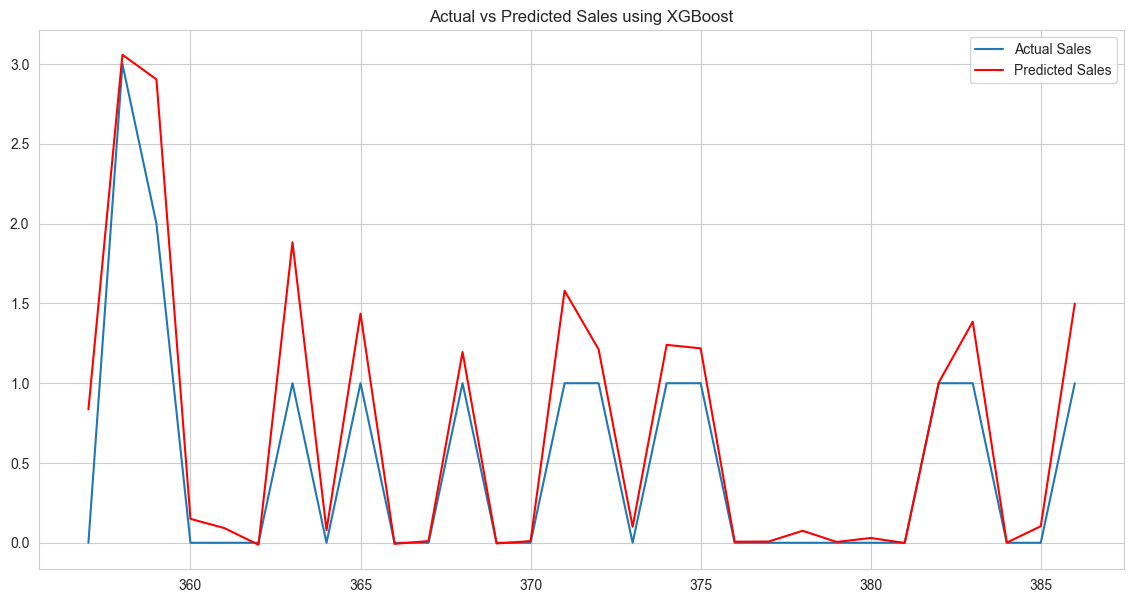

In [31]:
w_start = 0
w_end = w_start + 30

plt.figure(figsize=(14, 7))
plt.plot(y_test.index[w_start:w_end], y_test.values[w_start:w_end], label='Actual Sales')
plt.plot(y_test.index[w_start:w_end], y_pred[w_start:w_end], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.savefig('../resources/xgboost_forecast.png')
plt.show()

## Log Experiment with MLflow

In [ ]:
with mlflow.start_run(run_name='XGB_retail_demand_analysis_best_model'):
    mlflow.log_params(parameters)
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('../resources/xgboost_forecast.png')
    mlflow.xgboost.log_model(model, 'model')